In [2]:
from graphviz import Digraph

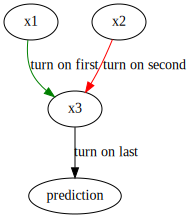

In [2]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'prediction')

dot.edge('1', '3', 'turn on first', color='green')
dot.edge('2', '3', 'turn on second', color='red')
dot.edge('3', 'y', 'turn on last')
dot

BFS based flow fails because cannot backprop credit to the green and red edge without linearization.

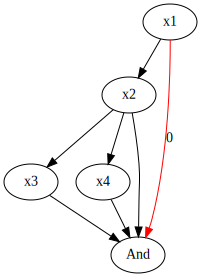

In [3]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails node first flow (flow0.py) because it assumes the red edge always appear first thus giving 0 contribution to it.

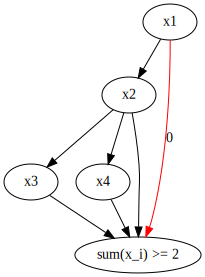

In [4]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'sum(x_i) >= 2')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails edge first flow (flow1.py) because the red edge can only appear first or last.

This means edge first flow treats direct connections as unbreakable functions; Is this a reasonable assumption? 

Perhaps what we want is **cut invariance**: different cuts of model and data shouldn't affect attribution of edges in the data side of the causal graph. Note that this is a weaker form of implementation invariance. Cut invariance is necessary because otherwise each cut would need a different visualization, which undermines the purpose of studying the flow of information as a single system.

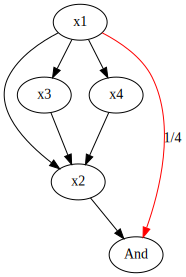

In [5]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '13', '14', '32', '42', '2y'])
dot.edge('1', 'y', color='red', label='1/4')
dot

This fails path first flow (permuting path) because I can make the red edge contribution as little as possible by adding intermediate nodes.

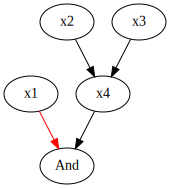

In [6]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['4y', '24', '34'])
dot.edge('1', 'y', color='red')
dot

This fails edge first backtrack (trace from the target instead of from the source) because it assumes x1 happens first twice as often as x2 and x3, which is not a justifiable assumption. Note that path first flow would work in this case (there is no path first back tracing b/c path first assumes every path is equally likely).

## Solutution?

Edge first backtrack to single source: Trace from the target to the sources one at a time in the order of node activation

# Regular path based Shapley value is not cut invariant

In the following case, if D=(x3, x2, x1), then edges have contribution of 1/3, but if D=(x1), edges have contribution of 1/2, violating cut invariance.

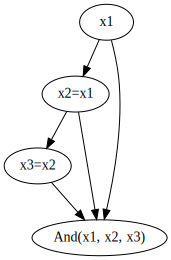

In [7]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x2')
dot.node('y', 'And(x1, x2, x3)')

dot.edges(['12', '23', '2y', '1y', '3y'])
dot

# Axiom: expanding a node shouldn't affect contribution (implementation invariance)

A simple graph


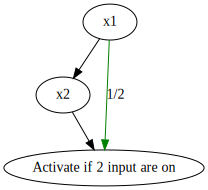

In [8]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

adding an intermediate node from x1 to x2


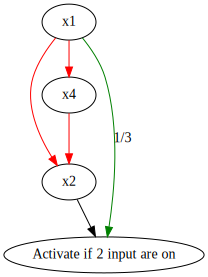

In [9]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot

This can be resolved by requiring always copy the source node when expanding a computational node.

adding an intermediate node from x1 to x2


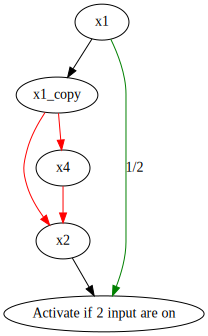

In [10]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('0', 'x1')
dot.node('1', 'x1_copy')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('0', 'y', color='green', label='1/2')
dot.edge('0', '1')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot

# DFS Flow violate implmentation invariance

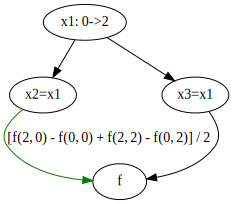

In [11]:
dot = Digraph()
dot.node('1', 'x1: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(2, 0) - f(0, 0) + f(2, 2) - f(0, 2)] / 2')
dot

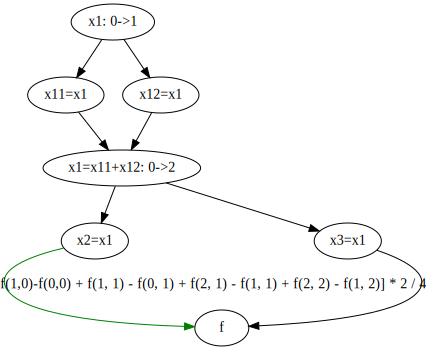

In [12]:
dot = Digraph()
dot.node('0', 'x1: 0->1')
dot.node('m', 'x11=x1')
dot.node('n', 'x12=x1')
dot.node('1', 'x1=x11+x12: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['0m', '0n', 'n1', 'm1', 
           '12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(1,0)-f(0,0) + f(1, 1) - f(0, 1) + f(2, 1) - f(1, 1) + f(2, 2) - f(1, 2)] * 2 / 4')
dot

We just expand the x1 node. This expansion of the node would break the attribution downstream because x1 can change from 0 to 1 and then 1 to 2 whereas in the previous case x1 only changes from 0 to 2. 

The foundamental problem is that expanding a node will create new intermediate state that is undesirable. If the computational graph is a tree, we are fine because there's only one way to reach a node from the source, therefore void of any intermediate value.

In fact we can show that **no average of path ordering attribution method is implementation invariant**

# Average of path ordering methods is not implementation invariant

We define average of path ordering methods as methods that give credit to path based on the marginal difference an coalition before and after the path is added, followed by averaging the result for different orderings. Shapley flow and Shapley value are examples of path based methods.

**Implementation invariance** refers to the constraint that revealing (or hiding) the implementation of a node doesn't affect the contribution of path exterior to the node. We show that no path ordering is implementation invariant given the pay off function we described above.

To see that, consider the following graph (one can add intermediate node on each edge if multi graph is not allowed):

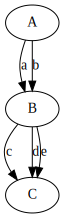

In [13]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')

dot.edge('A', 'B', label='a')
dot.edge('A', 'B', label='b')
dot.edge('B', 'C', label='c')
dot.edge('B', 'C', label='d')
dot.edge('B', 'C', label='e')
dot

Note that by implementation invariance, one can combine A and B to form a super node or combine B and C (or combine A, B, and C). If we combine A and B, observe that the path in the original graph [ac, bc] must appear together (no other path in between those two path) because otherwise we would have created new state of B that doesn't exist in the simplified graph. Similarly, [ad, bd] must be atomic (appear together). Same goes for [ae, be]. 

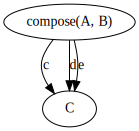

In [14]:
dot = Digraph()
# dot.node('A')
dot.node('B', 'compose(A, B)')
dot.node('C')

# dot.edge('A', 'B', label='a')
# dot.edge('A', 'B', label='b')
dot.edge('B', 'C', label='c')
dot.edge('B', 'C', label='d')
dot.edge('B', 'C', label='e')
dot

By the same argument (an ordering in the simplified graph must be matched by ordering in the expanded graph), we know [ac, ad, ae] and [bc, bd, be] must be atomic. However, one can check that no ordering of input to target paths satisfy these 5 atomic constraints simultaneously. 

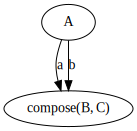

In [15]:
dot = Digraph()
dot.node('A')
dot.node('B', 'compose(B, C)')
# dot.node('C')

dot.edge('A', 'B', label='a')
dot.edge('A', 'B', label='b')
#dot.edge('B', 'C', label='c')
#dot.edge('B', 'C', label='d')
#dot.edge('B', 'C', label='e')
dot

We can consider every subset is given a different value and thus it is impossible to satisfy all orderings.

**My intuition is that all discrete value based feature attribution methods are not impelementation invariant because of intermediate values. Continous methods won't have this issue because all intermediate values are already anticipated. My guess is that if intermediate state does not introduce new model output values (in particular just toggles between the original output values), implementation invariance is possible!**

# Prefer distributed shapley flow over edge based shapley flow

We prefer distributed shapley flow over edge based shapley flow because the former's axiom is smaller. To see that, observe that only dumminess and symmetry differs (the former doesn't have symmetry). Since all dummy player works only on the model boundary (the rest are handled by cut invariance), observe that if a player has no impact in all execution history, it couldn't have an impact if it is turned on (this is just successive execution of the edge). 

# Ask scott why he thought otherwise???

# Impossiblity result?

The above example motivate us to investigate the compatibility of algorithms.

We know that the following axioms are congruent from our proof of uniquness of Shapley flow:
1. Efficiency
2. Linearity
3. Dummy player
4. Symmetry
5. Model agnosticity
6. cut invariance

Since Shapley flow is not consistent with implementation invariance, we want to figure out the minimum set of assumptions to be not implementation invariance.

1. Efficiency: must hold because otherwise we can then assign all path have 0 contribution.
2. Linearity: Not sure b/c all current methods satisfy linearity
3. Dummy player: must hold because otherwise deepLift style attribution (say just evenly split among all edges) can satisfy the rest
4. Symmetry: Not sure but based on the impossibility of average of path methods, it seems like the result doesn't depend on it.
5. Model agnosticity: must hold because if we only assume a differentiable model, integrated gradient (b/c gradient are linearized) could satisfy the rest of the axioms.
6. cut invariance: must hold because implementation invariance implies cut invariance, therefore violating cut invariance means violating implementation invariance.

Therefore the question is what's the impact of "Linearity" and "Symmetry" on implementation invariance. Furthermore, what is the implication of breaking implementation invariance.

I don't have an answer yet, but the following is an attempt.

An unsuccessful attempt:

Choose a model such that all of its internal variables are discrete (source nodes and the target node may not be). This makes gradient infeasible. Consider the following graph

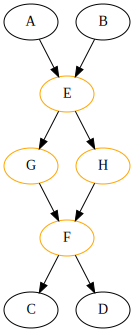

In [16]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')
dot.node('D')
dot.node('E', color='orange')
dot.node('F', color='orange')
dot.node('G', color='orange')
dot.node('H', color='orange')

dot.edges(['AE', 'BE', 'EG', 'GF', 'EH', 'HF', 'FC', 'FD'])
dot

Note that the nodes in orange can be collapsed into one node.

Implmenetation invariance requires the following:

$val(AE) = val(AEHFD) + val(AEGFD) + val(AEHFC) + val(AEGFC)$

$val(BE) = val(BEHFD) + val(BEGFD) + val(BEHFC) + val(BEGFC)$

$val(FC) = val(AEHFC) + val(AEGFC) + val(BEHFC) + val(BEGFC)$

$val(FD) = val(AEHFD) + val(AEGFD) + val(BEHFD) + val(BEGFD)$

$val(AE + FD) = val(AEHFD) + val(AEGFD)$

$val(AE + FC) = val(AEHFC) + val(AEGFC)$

$val(BE + FD) = val(BEHFD) + val(BEGFD)$

$val(BE + FC) = val(BEHFC) + val(BEGFC)$

The value of quantities on the left of the equation are derived from a collapsed network, so their value is determined and would be consistent with the axioms. Then we have 8 variables (paths) on the right with 8 equations.

Unfortunately only 4 of the equations are linearly independent. If somehow it is linearly dependent, then assume duminess we could have come up with a situtation where it is not solvable.

# Can we relax the axioms?


1. Efficiency: $\sum_{i \in \mathcal{P}} \psi_\nu(i) = \nu(\mathcal{P}) - \nu(\{\})  = f(\boldsymbol{x}) - f(\boldsymbol{x'})$
2. Linearity: $\psi_{\alpha u + \beta v} = \alpha \psi_{u} + \beta \psi_{v}$ for any payoff functions $u$ and $v$ and scalars $\alpha$ and $\beta$
3. Dummy player: $\psi_\nu(i) = 0$ if $\nu(S \cup \{i\} )=\nu(S) \forall S \subseteq \mathcal{P} \backslash \{i\}$
4. Symmetry: For $i$, $j$ in $\mathcal{P}$, if $i$ and $j$ share all the nodes up to the cut set and $\nu(S \cup \{j\}) = \nu(S \cup \{i\})$ for all $S \subseteq \mathcal{P}$, then $\psi_\nu(i) = \psi_\nu(j)$
5. Cut invariance: for a fixed G, take arbitrary model boundaries $C1=(D1, M1)$ and $C2=(D2, M2)$, every path in $\text{paths}(D1) \cap \text{paths}(D2)$ have the same attribution with respect to the two cuts.

- Can we have 1-4 without 5: No. Consider the following two graphs: all non terminal nodes are copy of their parents, node colored as orange are in the data side of the boundary. The two attributions at different boundaries satisfy 1-4, but fails 5. They can be produced by applying regular shap to source to sink path.

### cut invariance seems to be implied by the first 4 attributions methods, otherwise there could be contradiction

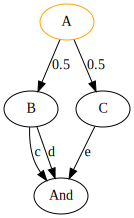

In [17]:
dot = Digraph()
dot.node('A', color='orange')
dot.node('B')
dot.node('C')
dot.node('D', 'And')

dot.edge('A', 'B', label='0.5')
dot.edge('A', 'C', label='0.5')
dot.edge('B', 'D', label='c')
dot.edge('B', 'D', label='d')
dot.edge('C', 'D', label='e')
dot

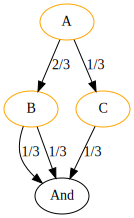

In [18]:
dot = Digraph()
dot.node('A', color='orange')
dot.node('B', color='orange')
dot.node('C', color='orange')
dot.node('D', 'And')

dot.edge('A', 'B', label='2/3')
dot.edge('A', 'C', label='1/3')
dot.edge('B', 'D', label='1/3')
dot.edge('B', 'D', label='1/3')
dot.edge('C', 'D', label='1/3')
dot

- Can we have 1-3, 5 without 4: No. Consider the same graph: as long as edge a and b has combined attribution of $0.5$, it will satisfy axioms 1 to 3 and 5, but may fail 4. This means 1-3 and 5 is not sufficient to determine a unique attribution.

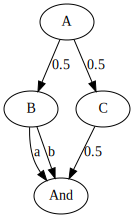

In [19]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')
dot.node('D', 'And')

dot.edge('A', 'B', label='0.5')
dot.edge('A', 'C', label='0.5')
dot.edge('B', 'D', label='a')
dot.edge('B', 'D', label='b')
dot.edge('C', 'D', label='0.5')
dot

- Can we relax 5: No. Relaxing 5 to only require edge contribution to be invariant is insufficient because it places only $\sum_{n \in Nodes(G)} \text{OutDegree}(n)$ constraints on possible $\Pi_{n \in Nodes(G)} \text{OutDegree}(n)$ variables (paths), which is underdetermined. Also, cut invariance is with respect to the explanation unit. Since the explanation unit is path, it is more natural as well.

# Asynchronous (distributed) nodes model

An asynchrous node model specifies the following physical process.
A node can receive and emit information through the directed edges but each edge could have arbitrary delay. 
Upon new message come in, the node uses its most recently recieved message (starts from baseline value of its source node) to compute a new message and send it out.

## Possible ways to attribute credit

### Bruteforce: consider every ordering of messages (can be repeated), the difference in the target node's output is attributed to the edge that transmitted the most recent message

Cut invariance is necessary for uniqueness result because this credit assignment does not specify credit for non-cut set edges (cannot handle the "Y" case).

However, cut invariance does not work with this definition because it requires dowstream nodes to be atomic (see the impossibility result, otherwise will have intermediate states evaluated at the cut set), which violate some ordering of messages. Execution order is a property of the graph, not the implementation of the node, but restricting execution order to be cut invariant is not justifiable. 

### Axiom based

An edge in the cut set is dummy if under all message receiving history (or paritial history from time 0 to the current time), receiving a message from this edge has no impact on the model.

Two edges of the same source in the cut set are symmetric if under all message receiving order history (or partial history from time 0 to the current time), 
swapping the receiving order of the two edges have no impact on the target node's output.

Need cut invariance because only receiving data in the cut set would change the model output (dummy and symmetry only specifies how cut set should behave, not upstream nodes).

If we define a game on the evaluation of history, then with only dummy player, cut invariance, linearity, and efficiency, the attribution is uniquely the dfs solution. The carrier game in this case is any history containing a partial history. 

# Why dfs does not satisfy dummy edge

The foundamental reason is that dfs will evaluate output difference on invalid coaliation (state of the network that doesn't corresponds to any activated set of edges).

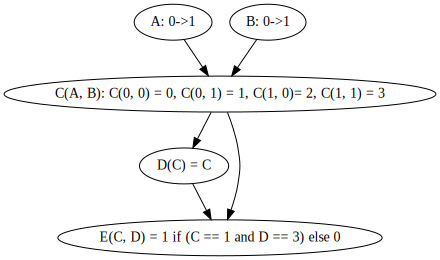

In [20]:
dot = Digraph()
dot.node('A', label='A: 0->1')
dot.node('B', label='B: 0->1')
dot.node('C', label='C(A, B): C(0, 0) = 0, C(0, 1) = 1, C(1, 0)= 2, C(1, 1) = 3')
dot.node('D', label='D(C) = C')
dot.node('E', label='E(C, D) = 1 if (C == 1 and D == 3) else 0')

dot.edge('A', 'C')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('C', 'E')
dot.edge('D', 'E')
dot

Note that the setting C=1 and D=3 cannot be produced by any valid activation of edges because for E to see that C=1, the edge C to E must open, and D!=0 implies that C to D and D to E are also open, but then D=3 means that C=3, which is inconsistent with E seeing C being 1 despite C to D is open! This condition can be reached by DFS through traversing paths in the order of [BCDE, BCE, ACDE]. 

Since C=1 and D=3 is not a valid coalition, the evaluation of output for any valid coalition is always 0, meaning that all edges are dummy. Let's focus on edge contribution of D->E in running DFS. DFS either starts from A->C or B->C. If we start from A->C, we does not reach C=1 and D=3, therefore all edges has contribution of 0. If we start from B->C, DFS produces orderings: [BCDE, BCE, ACDE, ACE],[BCDE, BCE, ACE, ACDE], [BCE, BCDE, ACDE, ACE], [BCE, BCDE, ACE, ACDE]. In each case, D->E has credit of [1, 0, 1, 0] respectively, giving it a total credit of 2, despite D->E is a dummy edge.

In general, this phenonmena can be reproduced by replacing the condition in $E$ with any setting of C, D that does not corresponds to a valid coalition of edges. 

# What is the issue?

Source nodes only have foreground and background values, but other nodes have intermediate values defined by the state of their source nodes.

# edge set algorithm is incorrect

Note that the edge from C to B is dummy but it does change B's value. My current algorithm would violate cut invariance for the following two views (give 0 credit to the red edge in the second case, while give non zero credit in the first case because the red edge could inherent C->F's credit in the credit pool).

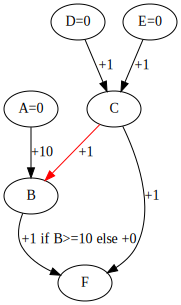

In [29]:
dot = Digraph()
dot.node('A', 'A=0')
dot.node('B')
dot.node('C')
dot.node('D', 'D=0')
dot.node('E', 'E=0')
dot.node('F')


dot.edge('A', 'B', label='+10')
dot.edge('C', 'B', label='+1', color='red')
dot.edge('D', 'C', label='+1')
dot.edge('E', 'C', label='+1')
dot.edge('C', 'F', label='+1')
dot.edge('B', 'F', label='+1 if B>=10 else +0')
dot

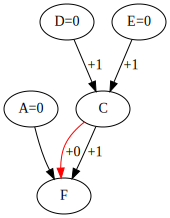

In [28]:
dot = Digraph()
dot.node('A', 'A=0')
dot.node('C')
dot.node('D', 'D=0')
dot.node('E', 'E=0')
dot.node('F')


dot.edge('A', 'F')
dot.edge('C', 'F', label='+0', color='red')
dot.edge('D', 'C', label='+1')
dot.edge('E', 'C', label='+1')
dot.edge('C', 'F', label='+1')
dot

# Locking of node is not modular

The method scott proposed is not modular: consider the following expansion of nodes

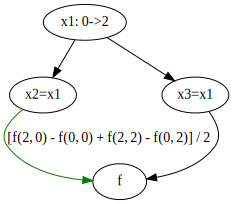

In [30]:
dot = Digraph()
dot.node('1', 'x1: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(2, 0) - f(0, 0) + f(2, 2) - f(0, 2)] / 2')
dot

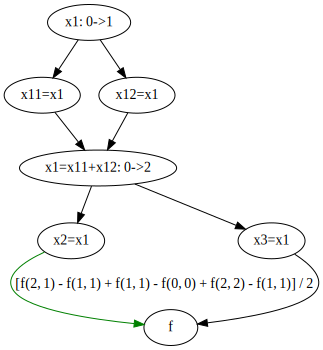

In [32]:
dot = Digraph()
dot.node('0', 'x1: 0->1')
dot.node('m', 'x11=x1')
dot.node('n', 'x12=x1')
dot.node('1', 'x1=x11+x12: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['0m', '0n', 'n1', 'm1', 
           '12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(2, 1) - f(1, 1) + f(1, 1) - f(0, 0) + f(2, 2) - f(1, 1)] / 2')
dot

They clearly don't have to be the same

# Solution that is modular

A simple solution that is modular is to fold the modules and proceed with DFS. Then when we traversing a source to target path, we can unfold the modules.

# Desirable properties of flow

1. Match flat Shap
2. Match tree Shap
3. Dummy edge? Dummy path give 0 attribution
4. Symmetric edges have same attribution
5. Cut invariance: so that we can summarize this information

Other honorable mentions
1. linearity
2. Modularity: expanding a node (single input and single ouput) shouldn't affect attribution


# Boundary consistency

**Theorem: for messages sent through boundary edges, if their ordering cannot be achieved by DFS through any edge ordering, it is not boundary consistent.**

Proof: An ordering (history) violating DFS on the boundary edges means that there exist edges on the boundary a, b, c such that b and c's lowest common ancestor node A is not (a, b, c)'s lowest common ancestor B, and there exist a substring in the ordering such that b, c appear once and b precede a, and a precede c in the substring. Now consider a boundary $B1=(D1, M1)$ including $a$ but not $b$ and $c$ (one can always do that by excluding $A$ in the cut and including $a$'s source node), and another boundary $B2=(D2,M1)$ including $a$, $b$, and $c$ in the cut set.

Then the following game would make attribution for $a$ inconsistent:

1. $v_{B2}(S)=0$ if S is DFS consistent with a history in B1
2. $v_{B2}(S)=1$ if S is DFS inconsistent with a history in B1 and ends in $a$

Here DFS consistent means that a history in B1 can be expanded into a history $S$ in B2 for edges in $M2-M1$, following any DFS ordering. Now we would have
$\phi_{v_{B1}}(a) = 0$ because $a$ is dummy in $B1$, but $\phi_{v_{B2}} \neq 0$ because $v_{B2}$ can be decomposed into carrier games involving inconsistent history that ends in $a$ (with the linearity axiom, $\phi_{v_{B2}} \neq 0$). Concluding the proof.

To make the argument more concrete, consider the following 2 boundaries.

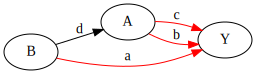

In [12]:
dot = Digraph()
dot.node('1', 'B')
dot.node('2', 'A')
dot.node('3', 'Y')

dot.edge('1', '2', 'd')
dot.edge('1', '3', 'a', color='red')
dot.edge('2', '3', 'c', color='red')
dot.edge('2', '3', 'b', color='red')
dot.attr(rankdir='LR')

dot.render('figures/inconsistent_history_red')
dot

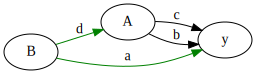

In [13]:
dot = Digraph()
dot.node('1', 'B')
dot.node('2', 'A')
dot.node('3', 'y')

dot.edge('1', '2', 'd', color='green')
dot.edge('1', '3', 'a', color='green')
dot.edge('2', '3', 'c')
dot.edge('2', '3', 'b')
dot.attr(rankdir='LR')

dot.render('figures/inconsistent_history_green')
dot

We construct a game so that two boundaries would give different values to the edge 'a'. Note that we have 8 possible message transmission histories ('c', 'b' can be transmitted only after 'd' has been transmitted): $\{adcb, adbc, dacb, dabc, dcab, dcba, dbac, dbca\}$. We use the same notation for carrier games and construct a game as the following:

$v_{red} = v_{red}^{dca} - v_{red}^{dcab} + v_{red}^{dba} - v_{red}^{dbac}$

Because of the linearity axiom, we have $\phi_{v_{red}}(a) > 0, \phi_{v_{red}}(b) < 0, \phi_{v_{red}}(c) < 0, \phi_{v_{red}}(d) = 0$.

However, when we consider the green boundary, the ordering $dcab$ and $dbac$ does not exist because $b$ and $c$ need to appear together to be DFS consistent. Therefore,
$v_{green} = 0$.

$a$ is now a dummy edge: $\phi_{v_{green}}(a) = 0 \neq \phi_{v_{red}}(a)$.

# DFS and scott's modularity idea may not be compatible

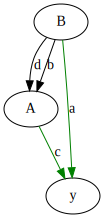

In [46]:
dot = Digraph()
dot.node('1', 'B')
dot.node('2', 'A')
dot.node('3', 'y')

dot.edge('1', '2', 'd')
dot.edge('1', '3', 'a', color='green')
dot.edge('2', '3', 'c', color='green')
dot.edge('1', '2', 'b')
dot

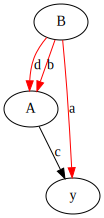

In [47]:
dot = Digraph()
dot.node('1', 'B')
dot.node('2', 'A')
dot.node('3', 'y')

dot.edge('1', '2', 'd', color='red')
dot.edge('1', '3', 'a', color='red')
dot.edge('2', '3', 'c')
dot.edge('1', '2', 'b', color='red')
dot

Now if we consider $c$ only send a single message, then $d$ and $b$ must be atomic in the ordering to give the same attribution to $a$

With the game $v_{red} = v_{red}^{dca} - v_{red}^{dcabc}$

Now $\phi_{v_{green}}(a) = 0 \neq \phi_{v_{red}}(a) = 1$.

This means Scott's algorithm could violate cut invariance (a cut at B now is no longer the same as Shap!).

This also shows that even without a module (as in this example), Scott's algorithm gives different credit from DFS.